# River runoff in CanESM2

There are several runoff related fields in CanESM2, as follows:


1. `MRRO`: runoff per unit land area in units of kg/m2.s which is equivalently mm/s. Runoff is generated by the land surface scheme when precipitation intensity exceeds infiltration capacity of soil or when top soil layer is saturated or when water drains through the bottom of soil layer.

2. `FLND`: This runoff is routed through a specified river network after multiplying with grid cell area. mm/s x (m2)/1E-03 = m3/s. So now we are in units of volume (and not depth) of water per unit time. As this volume of water flows down the river network it keeps getting accumulated and it's maximum at the river mouth. This is FLND from CanESM2 with units of m3/s. FLND is a gridded quantity which indicates how much water (m3/s) is flowing through a river in that grid cell. To see in what direction the water is flowing one needs to look at the river flow networks.

3. `FOUT`: When the time comes to dump this m3/s of water into the ocean, it gets divided by area of the ocean grid cell into which this water is being dumped giving FOUT back in the depth units (mm/s or kg/m2.s). In CanESM2, however,  we added P-E **from land locked lakes** to the FOUT field from the river routing subroutine so conserve water globally (note **not** P-E over the ocean). The location of grid cells to which P-E from land locked grid cells was flinged was read from a file. This is what leads to some negative values in FOUT. For regional models where this global conservation is irrelevant, FOUT can simply be clipped to zero. The change in FOUT should not be heavily dependent on this.

4. `ROUT`: this is FOUT, which has been spread over 2 AGCM cells away from the coast to avoid negative salinity near rivermouths.

All the above terms are prognostic variables computed inline within CanESM2. The plots below show the propoerties of these fields for a historical and RCP85 run from CanESM2.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

In [26]:
ds_idr = xr.open_dataset('idr_canesm2_rcp85/rout/rout_CanESM2_r1i1p1_200601-210012.nc')['ROUT']
ds_igm = xr.open_dataset('idr_canesm2_rcp85/rout/sc_igm_1850_2005_cp_rout_1850011612-2005121612.nc')['ROUT']

fout_idr = xr.open_dataset('idr_canesm2_rcp85/fout/sc_idr_2006_2010_cp_fout_200601-210012.nc')['FOUT']
flnd_idr = xr.open_dataset('idr_canesm2_rcp85/flnd/sc_idr_2006_2010_cp_flnd_200601-210012.nc')['FLND']

ds_areacella = xr.open_dataset('areacella_fx_CanESM2_historical_r0i0p0.nc')['areacella']
ds_sftlf = xr.open_dataset('sftlf_fx_CanESM2_historical_r0i0p0.nc')['sftlf']

In [27]:
# The latitudes differ slightly. This is not real, it is in the conversion to NetCDF
ds_idr['lat'] = ds_igm.lat
ds_idr['lon'] = ds_igm.lon

fout_idr['lat'] = ds_igm.lat
fout_idr['lon'] = ds_igm.lon

flnd_idr['lat'] = ds_igm.lat
flnd_idr['lon'] = ds_igm.lon

# Look at climatological means and mins

Note the similarities between FOUT and ROUT - within ROUT having broader (spread) distributions of runoff. Also note that both FOUT and ROUT can be negative.

Text(0.5, 1.0, 'ROUT min (idr)')

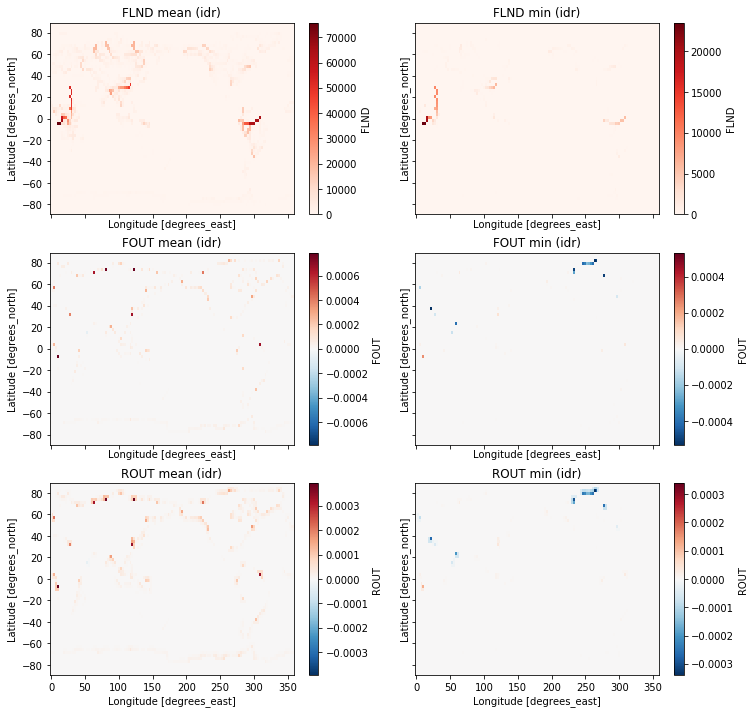

In [34]:
fig, ((axtl, axtr), (axml, axmr), (axbl,axbr)) = plt.subplots(3,2, figsize=(12,12), sharex=True, sharey=True)

flnd_idr.mean(dim='time').plot(ax=axtl, cmap='Reds')
axtl.set_title('FLND mean (idr)')

flnd_idr.min(dim='time').plot(ax=axtr, cmap='Reds')
axtr.set_title('FLND min (idr)')

fout_idr.mean(dim='time').plot(ax=axml)
axml.set_title('FOUT mean (idr)')

fout_idr.min(dim='time').plot(ax=axmr)
axmr.set_title('FOUT min (idr)')

ds_idr.mean(dim='time').plot(ax=axbl)
axbl.set_title('ROUT mean (idr)')

ds_idr.min(dim='time').plot(ax=axbr)
axbr.set_title('ROUT min (idr)')

## Difference between ROUT and FOUT

- Note that ROUT is just FOUT which has been spead over a wider ocean area. Hence the negative values at the point of input, and positive values surrounding those on the ocean side, in the anomaly plot below.

Text(0.5, 1.0, 'ROUT - FOUT mean (idr)')

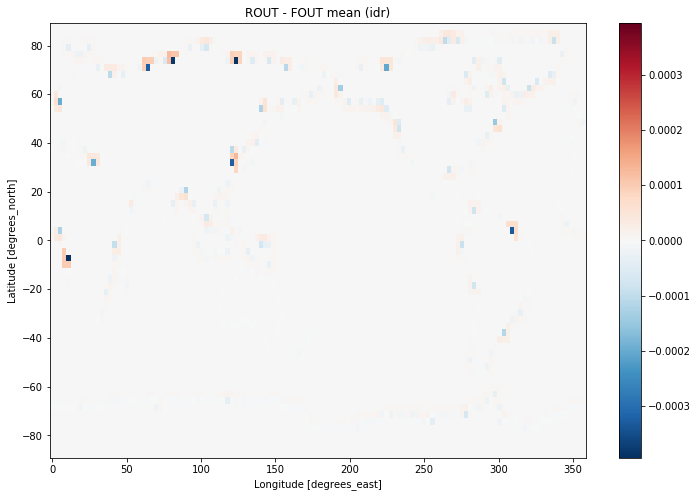

In [38]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
(ds_idr.mean(dim='time') - fout_idr.mean(dim='time')).plot(ax=ax)
ax.set_title('ROUT - FOUT mean (idr)')

## Difference between idr and igm (RCP85-historical)

Change in runoff due to climate change, simple mean over the experiments.

Text(0.5, 1.0, 'ROUT mean (idr - igm)')

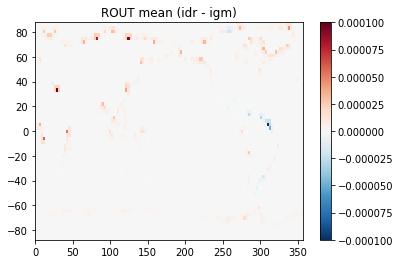

In [39]:
plt.pcolormesh(ds_idr.lon, ds_idr.lat, (ds_idr.mean(dim='time').values - 
                                        ds_igm.mean(dim='time').values), 
               cmap='RdBu_r', vmin=-0.0001, vmax=0.0001)
plt.colorbar()
plt.title('ROUT mean (idr - igm)')

# Global integrals

## Simple `ROUT` ih historical  / RCP85 runs

In [11]:
global_area = ds_areacella.sum(dim=('lon', 'lat'))

rout_global_igm = (ds_igm*ds_areacella*(1.0-ds_sftlf/100.)).sum(dim=('lon', 'lat'))
rout_global_idr = (ds_idr*ds_areacella*(1.0-ds_sftlf/100.)).sum(dim=('lon', 'lat'))

Text(0.5, 1.0, 'Globally integrated runoff')

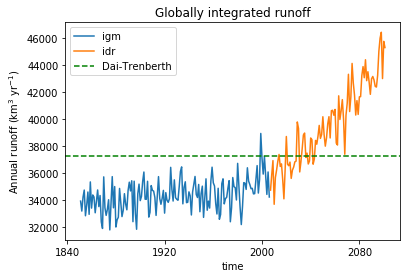

In [12]:
#kg_s_to_km3_yr = (3600*24*365)/(1000^8)
kg_s_to_km3_yr = (3600*24*365)/(1000.**4.0)
(rout_global_igm.resample(time='1A').mean()*kg_s_to_km3_yr).plot(label='igm')
(rout_global_idr.resample(time='1A').mean()*kg_s_to_km3_yr).plot(label='idr')
plt.gca().axhline(37300, color='g', linestyle='--', label='Dai-Trenberth')
plt.legend()
plt.ylabel('Annual runoff (km$^3$ yr$^{-1}$)')
plt.title('Globally integrated runoff')

## Comparing `ROUT` and `FOUT`

- We expect the global integrals to be equal, since only the distributions should differ due to spreading. This is shown to be true below.

In [40]:
fout_global_idr = (fout_idr*ds_areacella*(1.0-ds_sftlf/100.)).sum(dim=('lon', 'lat'))

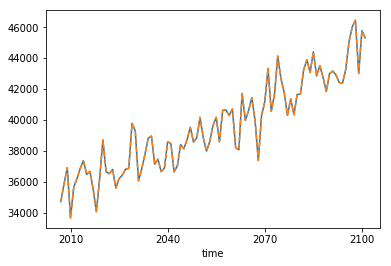

In [41]:
(fout_global_idr.resample(time='1A').mean()*kg_s_to_km3_yr).plot(label='FOUT')
(rout_global_idr.resample(time='1A').mean()*kg_s_to_km3_yr).plot(label='ROUT', linestyle='--')